In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter


import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy

from scipy.stats import t,linregress

from precip_model_functions import *

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [4]:
orog1 = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z/9.80665

timedisc=6
leveldisc=4

nepal1    = [80, 90, 25, 30]
pakistan1 = [62, 74, 24, 36]
mexico1   = [360-110,360-100, 18, 30]
chile1    = [360-72, 360-68, -37, -25]

extent = 15
nepal    = np.array(nepal1   ) + extent*np.array([-1,1,-1,1])
pakistan = np.array(pakistan1) + extent*np.array([-1,1,-1,1])
mexico   = np.array(mexico1  ) + extent*np.array([-1,1,-1,1])
chile    = np.array(chile1   ) + extent*np.array([-1,1,-1,1])

nepals    = np.array(nepal1   ) + 30.*np.array([-1,1,-1,1])
pakistans = np.array(pakistan1) + 30.*np.array([-1,1,-1,1])
mexicos   = np.array(mexico1  ) + 30.*np.array([-1,1,-1,1])
chiles    = np.array(chile1   ) + 30.*np.array([-1,1,-1,1])

rx5nepal    = ["19980706","19990710","20000608","20011003","20020721","20030710","20040708","20050711","20060708","20070724","20080615","20090727","20100719","20110718","20120915","20130627"]
rx5pakistan = ["20000714","20010711","20020227","20030217","20041229","20050210","20061204","20070627","20080803","20090723","20100727","20110831","20120907","20130203"]
rx5mexico   = ["20000915","20010910","20020917","20030921","20040902","20051008","20060915","20070903","20080823","20091019","20100703","20110825","20120927","20130917"]
rx5chile    = ["20000626","20010730","20020515","20030522","20040723","20050628","20060712","20070328","20080520","20090814","20100616","20110826","20120526","20130529"]


## (Mean omega over box) vs (mean upslope flow) temporal Regression slope, Nepal, 3 boxes (divided in horizontal), 3 upslope flow models, all levels

In [6]:
omegas = retrieveomega(rx5nepal,nepal1,"nepal",["oper.an.pl.128_135_w.ll025sc","upslopeomegamean200","upslopeomegasin","upslopeomega700"])

In [9]:
omegas_timemean = [xr.concat(omegas[i][:],'time').mean("time") for i in range(len(omegas))]

### Upslope omega at 700 hpa

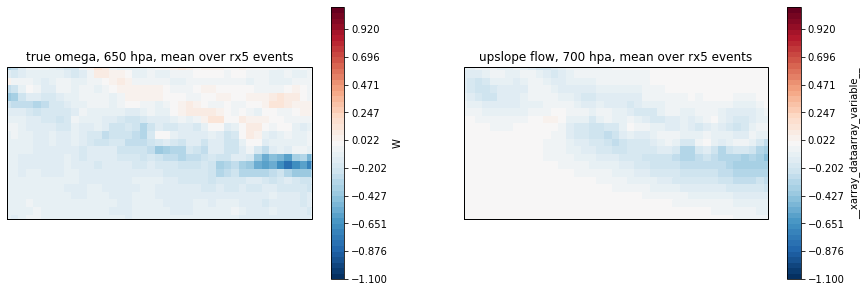

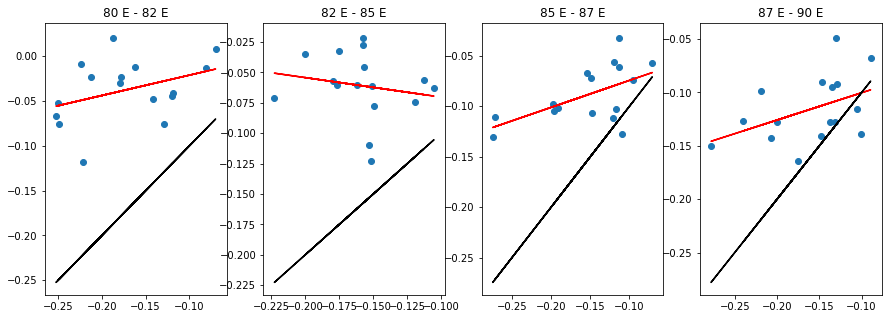

In [28]:
omegatrue_spatial = omegas_timemean[0].sel(level=800.).W
omega700_spatial = omegas_timemean[3].__xarray_dataarray_variable__

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection': ccrs.PlateCarree()})

extent=1.1
country=nepal1

ax1.coastlines()
omegatrue_spatial.plot(ax=ax1,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax1.set_extent(country)
ax1.set_title("true omega, 650 hpa, mean over rx5 events")

ax2.coastlines()
omega700_spatial.plot(ax=ax2,transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
ax2.set_extent(country)
ax2.set_title("upslope flow, 700 hpa, mean over rx5 events")

n=4
dl = (nepal1[1]-nepal1[0])/n
omegatrue = np.array([[np.array(omegas[0][j].sel(longitude=slice(nepal1[0]+i*dl,nepal1[0]+(i+1)*dl),latitude=slice(nepal1[3],nepal1[2])).sel(level=650.).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for i in range(n)])
omega700 = np.array([[np.array(omegas[3][j].sel(longitude=slice(nepal1[0]+i*dl,nepal1[0]+(i+1)*dl), latitude=slice(nepal1[3],nepal1[2])).mean(["latitude","longitude"]).to_array())[0] for j in range(len(omegas[0]))] for i in range(n)])

f,ax = plt.subplots(1,n,figsize=(15,5))
ax=ax.reshape(-1)
for i in range(n):
    l = linregress(omegatrue[i,:],omega700[i,:])
    ax[i].plot(omegatrue[i,:],l.intercept+l.slope*omegatrue[i,:],"r")
    ax[i].plot(omegatrue[i,:],omegatrue[i,:],"k")
    ax[i].scatter(omegatrue[i,:],omega700[i,:])
    ax[i].set_title("%i E - %i E"%(nepal1[0]+i*dl,nepal1[0]+(i+1)*dl))


### Mean upslope omega over [ps -- ps+200mb]

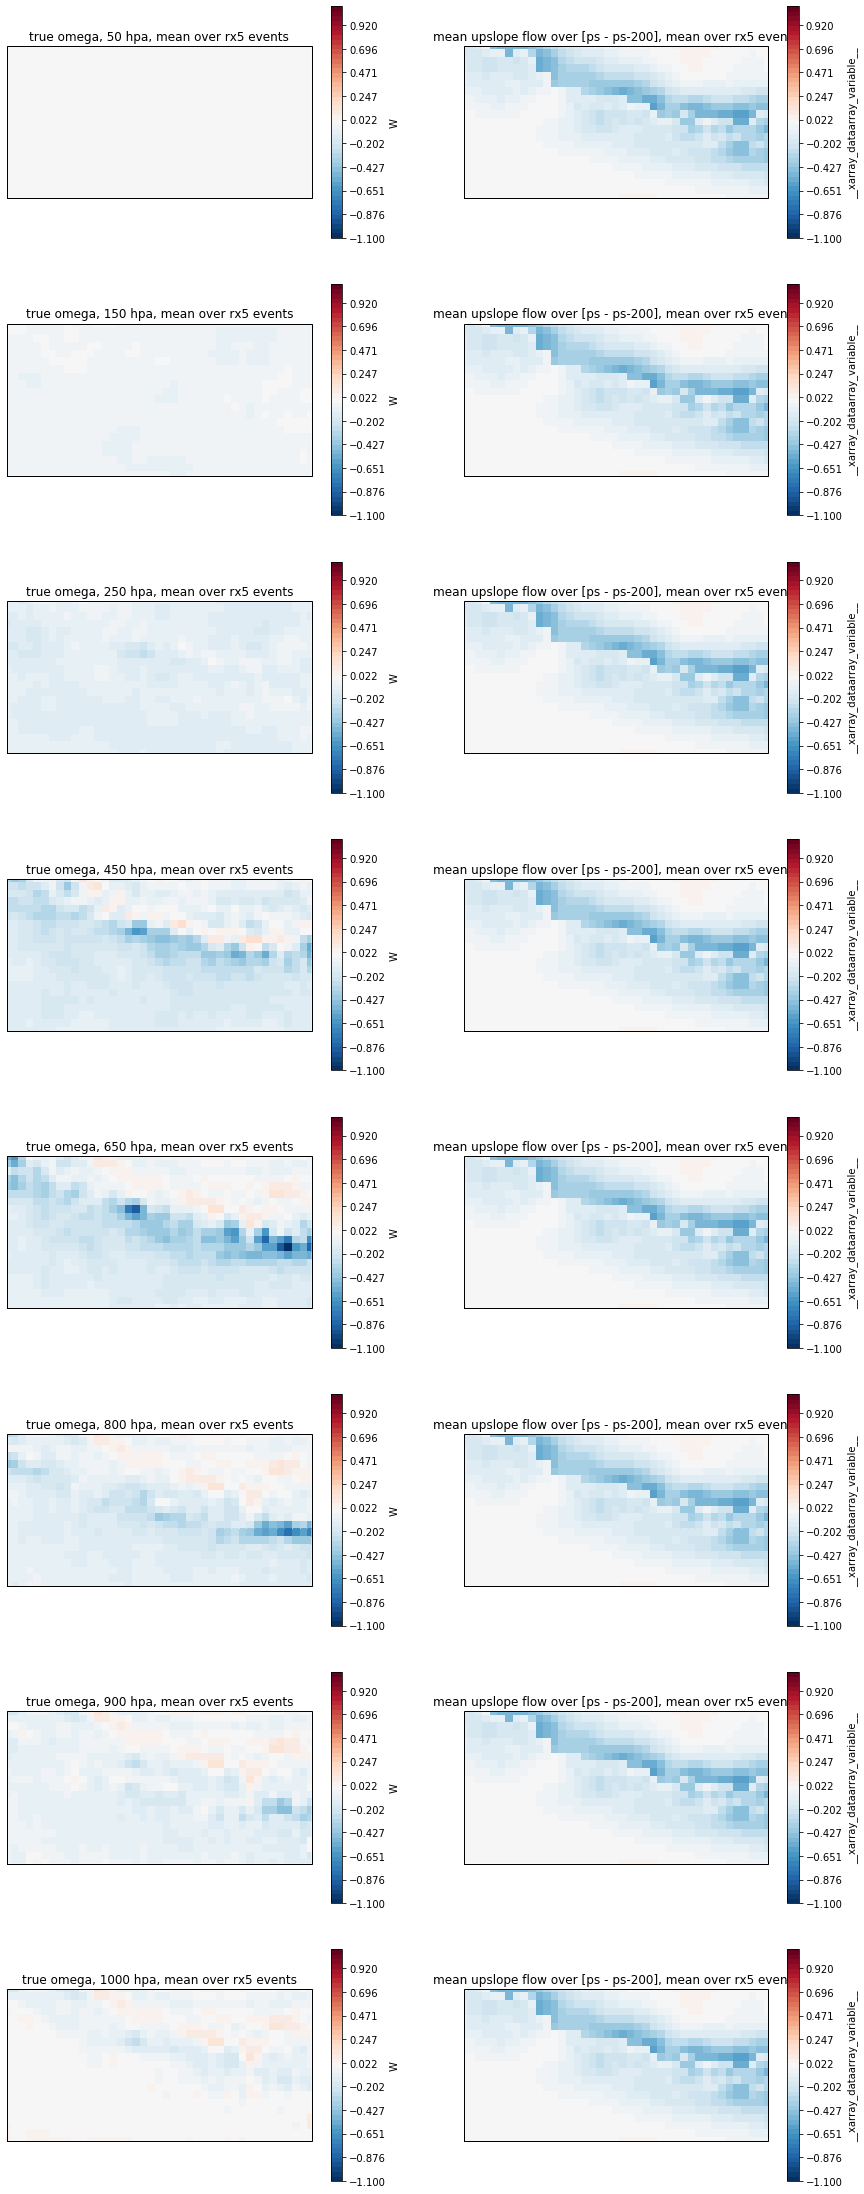

In [24]:
extent=1.1
country=nepal1
nl=len(omegas[0][0].level)
levs = np.array(omegas[0][0].level)
fig, ax = plt.subplots(nl,2,figsize=(15,5*nl),subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(nl) : 
    omegatrue_spatial = omegas_timemean[0].isel(level=i).W
    omegamean_spatial = omegas_timemean[1].isel(level=i).__xarray_dataarray_variable__

    ax[i][0].coastlines()
    omegatrue_spatial.plot(ax=ax[i][0],transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50),cmap=plt.cm.RdBu_r)
    ax[i][0].set_extent(country)
    ax[i][0].set_title("true omega, %i hpa, mean over rx5 events"%levs[i])

    ax[i][1].coastlines()
    omegamean_spatial.plot(ax=ax[i][1],transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50))
    ax[i][1].set_extent(country)
    ax[i][1].set_title("mean upslope flow over [ps - ps-200], mean over rx5 events")


### Sinusoidal upslope omega

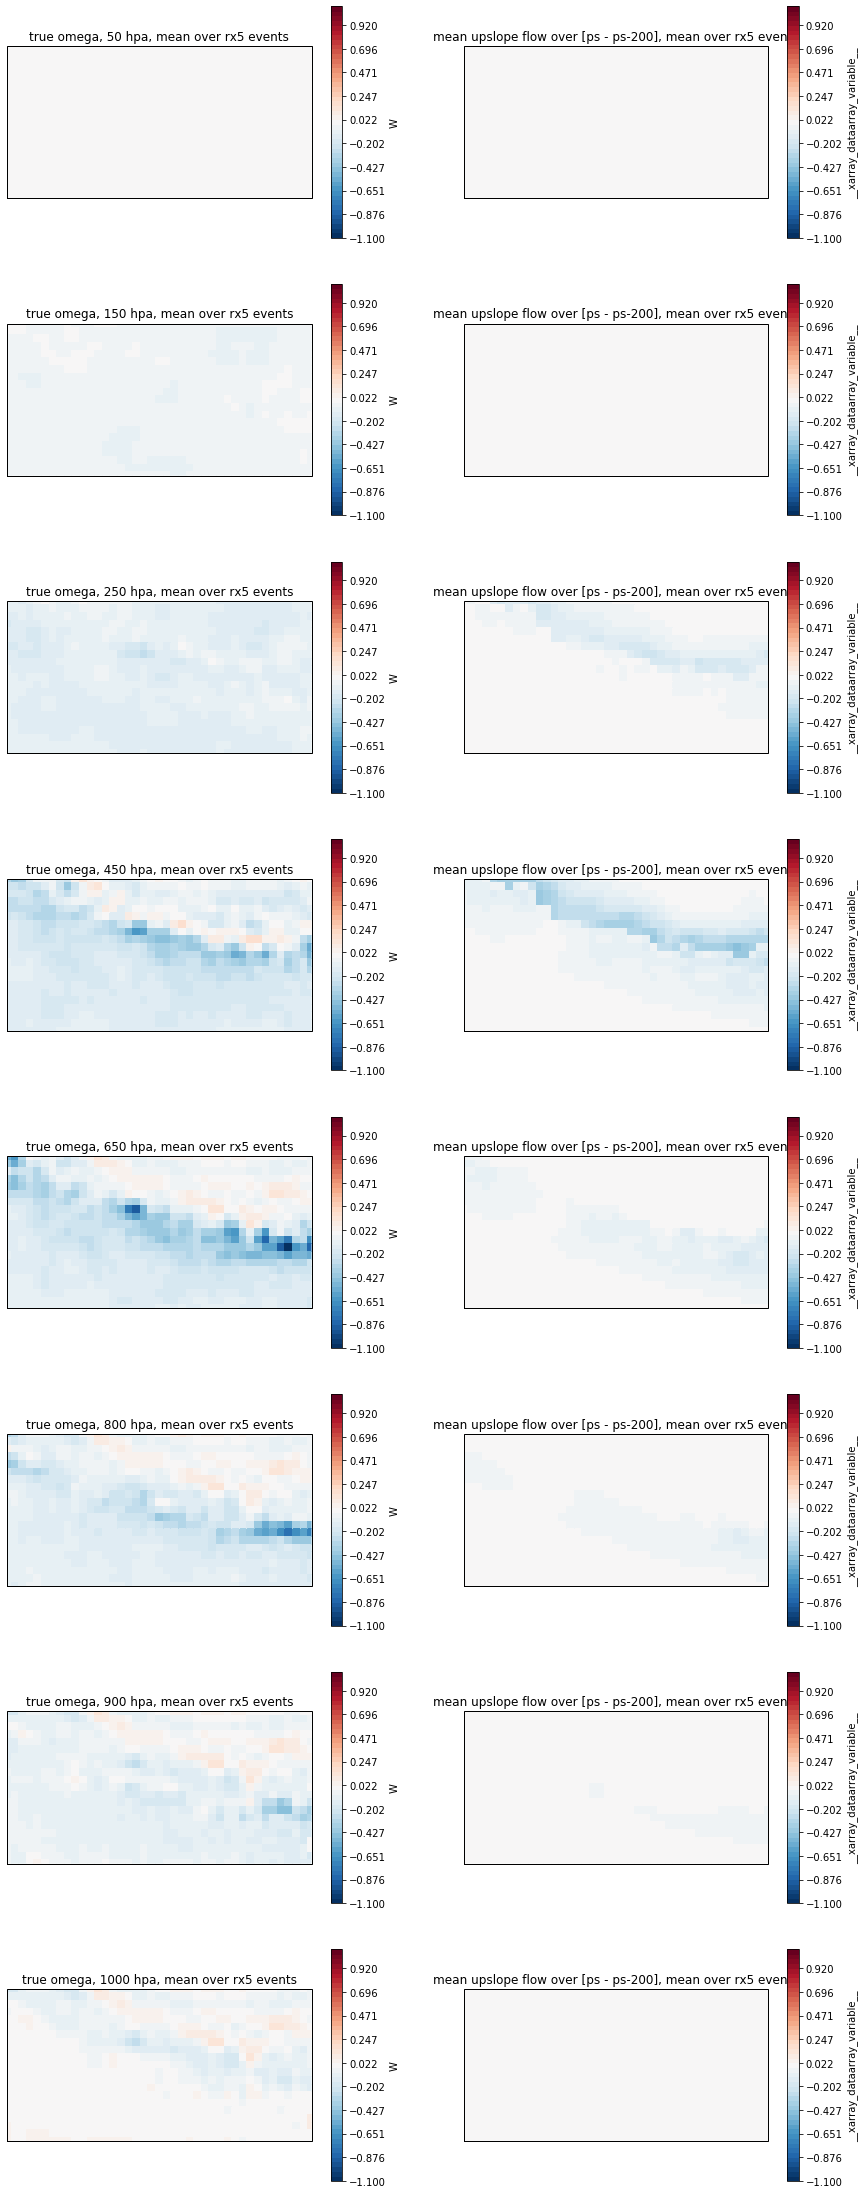

In [25]:
extent=1.1
country=nepal1
nl=len(omegas[0][0].level)
levs = np.array(omegas[0][0].level)
fig, ax = plt.subplots(nl,2,figsize=(15,5*nl),subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(nl) : 
    omegatrue_spatial = omegas_timemean[0].isel(level=i).W
    omegasin_spatial = omegas_timemean[2].isel(level=i).__xarray_dataarray_variable__

    ax[i][0].coastlines()
    omegatrue_spatial.plot(ax=ax[i][0],transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50),cmap=plt.cm.RdBu_r)
    ax[i][0].set_extent(country)
    ax[i][0].set_title("true omega, %i hpa, mean over rx5 events"%levs[i])

    ax[i][1].coastlines()
    omegasin_spatial.plot(ax=ax[i][1],transform=ccrs.PlateCarree(),levels=np.linspace(-extent,extent,50),cmap=plt.cm.RdBu_r)
    ax[i][1].set_extent(country)
    ax[i][1].set_title("mean upslope flow over [ps - ps-200], mean over rx5 events")


### Sinusoidal upslope omega - mean vertical profile

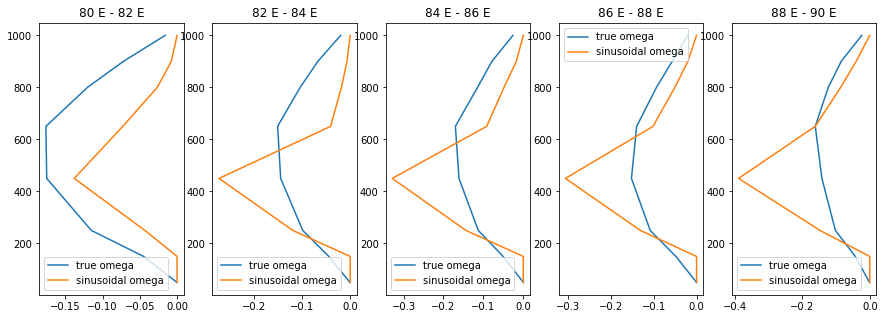

In [33]:
n=5
dl = (nepal1[1]-nepal1[0])/n

# dimensions  = models * slices * times

#print(omegas[0][0].level)

omegatrue_vertical = np.array([np.array(omegas_timemean[0].sel(longitude=slice(nepal1[0]+i*dl,nepal1[0]+(i+1)*dl),latitude=slice(nepal1[3],nepal1[2])).mean(["latitude","longitude"]).to_array())[0] for i in range(n)])
omegasin_vertical = np.array([np.array(omegas_timemean[2].sel(longitude=slice(nepal1[0]+i*dl,nepal1[0]+(i+1)*dl),latitude=slice(nepal1[3],nepal1[2])).mean(["latitude","longitude"]).to_array())[0] for i in range(n)])

levs = np.array(omegas_timemean[0].level)

f,ax = plt.subplots(1,n,figsize=(15,5))
for i in range(n):
    ax[i].plot(omegatrue_vertical[i],levs,label="true omega")
    ax[i].plot(4*omegasin_vertical[i],levs,label="sinusoidal omega")
    ax[i].set_title("%i E - %i E"%(nepal1[0]+i*dl,nepal1[0]+(i+1)*dl))
    ax[i].legend()